In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import joblib
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import cross_val_score,KFold,train_test_split
from sklearn.metrics import (accuracy_score,confusion_matrix,precision_score,recall_score,roc_auc_score,classification_report,
f1_score,roc_curve,log_loss)

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing data
df = pd.read_csv('cardio_train.csv', sep = ';')
df.sample(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
32738,47766,15318,2,168,62.0,120,90,1,1,1,0,1,0
40577,58983,20275,1,168,74.0,120,80,1,1,0,0,1,1
35068,51080,22597,1,145,65.0,150,80,1,1,0,0,1,1
46866,67922,22440,1,168,79.0,140,90,2,3,0,0,1,1
39584,57581,20302,2,168,90.0,120,80,1,1,0,0,0,0


### Imported data at a glance

In [3]:
# checking shape of data
df.shape

(69301, 13)

In [4]:
# checking data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           69301 non-null  int64  
 1   age          69301 non-null  int64  
 2   gender       69301 non-null  int64  
 3   height       69301 non-null  int64  
 4   weight       69301 non-null  float64
 5   ap_hi        69301 non-null  int64  
 6   ap_lo        69301 non-null  int64  
 7   cholesterol  69301 non-null  int64  
 8   gluc         69301 non-null  int64  
 9   smoke        69301 non-null  int64  
 10  alco         69301 non-null  int64  
 11  active       69301 non-null  int64  
 12  cardio       69301 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [5]:
#checking unique value in each row
df.nunique()

id             69301
age             8069
gender             2
height           108
weight           285
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

In [6]:
# checking the data description
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,50471.480397,19468.786280,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,28563.100347,2467.261818,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,988.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25745.000000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50494.000000,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,75150.000000,21326.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


### Data preprocessing

In [7]:
# converting age from days to years
df['age'] = df['age'] // 365

In [8]:
# converting gender into a binary variable
df['gender'] = df['gender'] - 1

In [9]:
# changing sign of negative blood pressure values
df['ap_lo'] = df['ap_lo'].map(lambda x: -1 * x if x < 0 else x)
df['ap_hi'] = df['ap_hi'].map(lambda x: -1 * x if x < 0 else x)

# dropping rows with diastolic blood pressure > systolic blood pressure
df = df.loc[df['ap_lo'] < df['ap_hi']]

# dropping rows with infeasible blood pressure values
df = df.loc[(df['ap_hi'] > 70) & (df['ap_hi'] < 200)]
df = df.loc[(df['ap_lo'] > 40) & (df['ap_lo'] < 160)]

In [10]:
# calculating bmi
df['bmi'] = df['weight'] / (df['height'] / 100)**2
df['bmi'] = df['bmi'].astype('int')

# dropping height and weight columns
df.drop(columns = ['height', 'weight'], inplace = True)

# dropping rows with infeasible bmi values
df = df.loc[(df['bmi'] > 10) & (df['bmi'] < 60)]

In [11]:
# dropping id column
df.drop(columns = ['id'], inplace = True)

In [12]:
# balancing classes
# undersampling from minority class
no_cardio = df.loc[df['cardio'] == 0]
cardio = df.loc[df['cardio'] == 1]
n = min(len(no_cardio), len(cardio))
no_cardio_reduced = no_cardio.sample(n = n, random_state = 0)
cardio_reduced = cardio.sample(n = n, random_state = 0)

In [13]:
df.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,61,0,130,80,2,2,0,0,1,0,28
1,40,0,110,70,1,1,0,0,1,1,26
2,60,0,120,80,1,1,0,0,1,0,25
3,39,1,120,80,1,1,1,1,1,0,31
4,64,0,120,80,1,1,0,0,1,0,25


### EDA

In [14]:
df1 = df.copy()
# converting ages into categories
min_age, max_age = df['age'].min(), df['age'].max()
df1['age'] = pd.cut(df1['age'], bins = [min_age-1,40,45,50,55,60,max_age+1], labels = ['under 40', '40-45', '45-50', '50-55', '55-60', 'over 60'])

# converting bmi into categories
min_bmi, max_bmi = df['bmi'].min(), df['bmi'].max()
df1['bmi'] = pd.cut(df1['bmi'], bins = [min_bmi-1,17.5,25,30,max_bmi+1], labels = ['underweight', 'normal weight', 'overweight', 'obese'])

# converting diastolic blood pressure into zone
min_diastolic_bp, max_diastolic_bp = df['ap_lo'].min(), df['ap_lo'].max()
df1['Diastolic Blood Pressure'] = pd.cut(df1['ap_lo'], bins = [min_diastolic_bp-1,80,90,120,max_diastolic_bp+1], labels = ['normal', 'stage 1', 'stage 2', 'stage 3'])

# converting Systolic blood pressure into zone
min_systolic_bp, max_systolic_bp = df['ap_hi'].min(), df['ap_hi'].max()
df1['Systolic Blood Pressure'] = pd.cut(df1['ap_hi'], bins = [min_systolic_bp-1,120,140,180,max_systolic_bp+1], labels = ['normal', 'stage 1', 'stage 2', 'stage 3'])

In [15]:
# checking count and percentage of diffrent values in each coloums
fx = df1[['gender','smoke','alco','active','cholesterol','gluc','age','bmi','Diastolic Blood Pressure','Systolic Blood Pressure','cardio']]

for column_index, column in enumerate(fx.columns):
    print('\x1b[1;31m'+'Effect of',column,'in occurrence of disease'+'\x1b[0m')
    print(fx.groupby([column])['cardio'].mean().round(3),'\n\n')

Effect of gender in occurrence of disease
gender
0    0.491
1    0.499
Name: cardio, dtype: float64 


Effect of smoke in occurrence of disease
smoke
0    0.496
1    0.468
Name: cardio, dtype: float64 


Effect of alco in occurrence of disease
alco
0    0.495
1    0.476
Name: cardio, dtype: float64 


Effect of active in occurrence of disease
active
0    0.532
1    0.485
Name: cardio, dtype: float64 


Effect of cholesterol in occurrence of disease
cholesterol
1    0.435
2    0.596
3    0.761
Name: cardio, dtype: float64 


Effect of gluc in occurrence of disease
gluc
1    0.475
2    0.587
3    0.616
Name: cardio, dtype: float64 


Effect of age in occurrence of disease
age
under 40    0.224
40-45       0.345
45-50       0.419
50-55       0.491
55-60       0.566
over 60     0.695
Name: cardio, dtype: float64 


Effect of bmi in occurrence of disease
bmi
underweight      0.260
normal weight    0.410
overweight       0.525
obese            0.637
Name: cardio, dtype: float64 


Effect of 

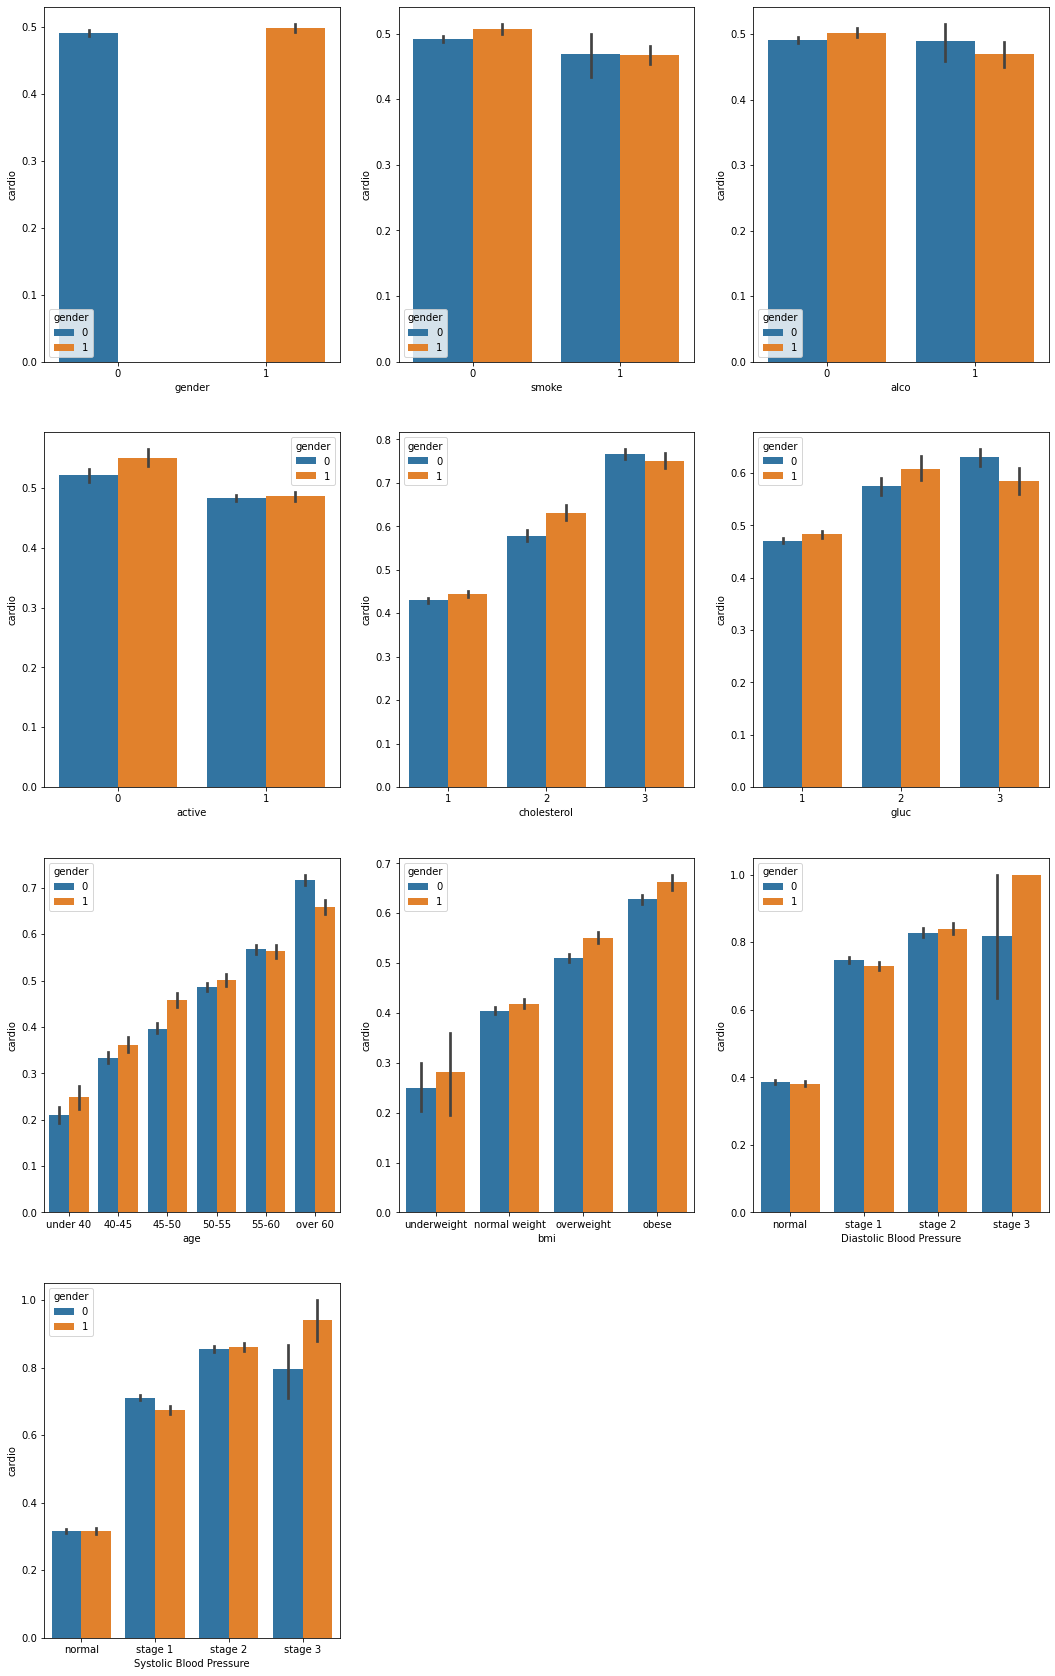

In [16]:
figure(num=None,figsize=(18,30))
for column_index, column in enumerate(fx.columns):
    if column == 'cardio':
        continue
    plt.subplot(4, 3, column_index+1)
    
    sns.barplot(y='cardio', x=column, data=fx,hue='gender')

#### From above we conclude that Gender, Alcohol, Smoking and Activity Level have almost no significant diffrence in matter of occurrence of disease while in case of Cholesterol, Glucose, Age, BMI, Diastolic Blood Pressure and Systolic Blood Pressure likelihood of disease increases as these factor increases.

In [17]:
# dividing dataset into input values 'x' and output value 'y'
x = df.drop(columns=['cardio'])
print('x dataset\n',x.sample(5),'\n')
y=df['cardio']
print('y datase\n',y.sample(5))
print(x.shape)
print(y.shape)

x dataset
        age  gender  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  bmi
44319   51       0    110     80            1     2      0     0       1   31
32472   51       0    120     80            1     1      0     0       1   22
9937    57       0    120     80            1     1      0     1       1   22
51087   46       0    120     70            1     1      0     0       1   16
28507   56       0    120     80            1     1      0     0       1   26 

y datase
 10277    1
60951    0
60366    0
55057    1
18660    1
Name: cardio, dtype: int64
(67762, 10)
(67762,)


In [18]:
# standardizes the data in x using standerd scaler technique
scale=StandardScaler()
x=scale.fit_transform(x)

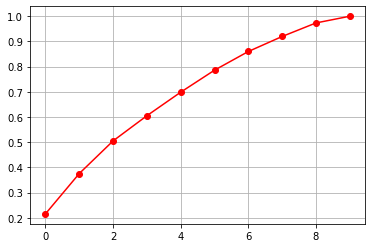

In [19]:
# using pca to find out the variance ratio for dimensionality-reduction
pca=PCA()
train_x1=pca.fit(x)

plt.plot(np.cumsum(pca.explained_variance_ratio_),'ro-')
plt.grid()

#### we will not use pca for dimensionality-reduction since this does'nt have much effect

### Bulding and comparing multipe classification model, to find out the best model

In [20]:
#creating models array with all the model
Models=[('SVC',SVC()),('GaussianNB',GaussianNB()),('SGDClassifier',SGDClassifier(random_state=10)),('LogisticRegression',LogisticRegression()),
        ('DecisionTreeClassifier',DecisionTreeClassifier(random_state=10)),('GradientBoostingClassifier',GradientBoostingClassifier()),
        ('LinearDiscriminantAnalysis',LinearDiscriminantAnalysis()),('RandomForestClassifier',RandomForestClassifier(random_state=10)),
        ('KNeighborsClassifier',KNeighborsClassifier()),('QuadraticDiscriminantAnalysis',QuadraticDiscriminantAnalysis())]

In [21]:
# loop to find out the maximum ayuray of all the model in models arrac along the range of random state
Model_array=[]
Random_state=[]
Max_accuracy_array=[]
for name,model in Models:
    max_accuracy=0    
    for random_state in range(10,99):
        train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=.2,random_state=random_state,stratify=y,shuffle=True)
        model.fit(train_x,train_y)
        pred=model.predict(test_x)
        
        accuracy=accuracy_score(test_y,pred)
        
        if accuracy>max_accuracy:
            max_accuracy=accuracy
            best_random_state=random_state
    
    Model_array.append(name)
    Random_state.append(best_random_state)
    Max_accuracy_array.append(max_accuracy)

In [22]:

# comparing the performances of all the model on accuracy basis
model_accuracy_performance = pd.DataFrame({'Model': Model_array,'Accuracy': Max_accuracy_array,'Random state': Random_state})
model_accuracy_performance.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Random state
5,GradientBoostingClassifier,0.742345,31
0,SVC,0.740795,66
3,LogisticRegression,0.735999,69
6,LinearDiscriminantAnalysis,0.734819,69
2,SGDClassifier,0.731499,13
1,GaussianNB,0.722128,29
9,QuadraticDiscriminantAnalysis,0.713495,69
7,RandomForestClassifier,0.712979,69
8,KNeighborsClassifier,0.706855,37
4,DecisionTreeClassifier,0.671512,70


### Conclusion

On basis of accuracy GradientBoostingClassifier model is performing the best with maximum accuracy score

In [23]:
# loop to find out the cross_val_score of all the model in models array, along a range of random state
Cross_val_score_array=[]
Standard_Deviation=[]
for name, model in Models:
    kf=KFold(n_splits=10,random_state=5)
    cscore=cross_val_score(model,x,y,cv=kf,scoring='accuracy')
    Cross_val_score_array.append(cscore.mean())
    Standard_Deviation.append(cscore.std())

In [24]:
# comparing the performances of all the model on crossval basis
model_cross_val_performance = pd.DataFrame({'Model': Model_array,'Cross val Acuracy': Cross_val_score_array,
                                            'Standard Deviation': Standard_Deviation})
model_cross_val_performance.sort_values(by='Cross val Acuracy', ascending=False)

,Model,Cross val Acuracy,Standard Deviation
5,GradientBoostingClassifier,0.734424,0.003492
0,SVC,0.733730,0.004887
3,LogisticRegression,0.727104,0.003704
6,LinearDiscriminantAnalysis,0.725407,0.004222
2,SGDClassifier,0.724993,0.003367
1,GaussianNB,0.711962,0.002936
9,QuadraticDiscriminantAnalysis,0.702164,0.004225
7,RandomForestClassifier,0.699301,0.007428
8,KNeighborsClassifier,0.696570,0.006935
4,DecisionTreeClassifier,0.661521,0.005102


### Conclusion
On basis of Cross val Acuracy GradientBoostingClassifier model is performing the best closly follow by LogisticRegression



### On basis of our compression of Accuracy score and Cross val score since GradientBoostingClassifier model since it performing best on given data we will proceed with it.

In [25]:
#using grid search to improve model..
param_grid={'max_depth':[4,5,6],'max_features':['auto','sqrt'],'min_samples_split':[4,5,6],
            'n_estimators':[200,300,400],'min_samples_leaf':[6,7,8]}
mod=GradientBoostingClassifier()
grid=GridSearchCV(estimator=mod,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=2)
grid_result=grid.fit(train_x,train_y)

In [26]:
grid_result.best_score_

0.7357634925270117

In [27]:
grid_result.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'n_estimators': 300}

In [28]:
grid_result.best_estimator_

GradientBoostingClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=8,
                           min_samples_split=5, n_estimators=300)

Model score is: 0.7360731941267616 

Accuracy score of model is :  0.7360731941267616 

The mean of cross_val_score for the model is: 0.7323826862162427 

Precision score of model is : 0.7508048937540245 

Recall score of model is : 0.6968474525623786 

Log loss score of model is : 9.115800261301368 

F1_score score of model is : 0.7228206121658272 

Confusion matrix for the model is : 
 [[5312 1548]
 [2029 4664]] 

Classification report for the model is : 
               precision    recall  f1-score   support

           0       0.72      0.77      0.75      6860
           1       0.75      0.70      0.72      6693

    accuracy                           0.74     13553
   macro avg       0.74      0.74      0.74     13553
weighted avg       0.74      0.74      0.74     13553
 



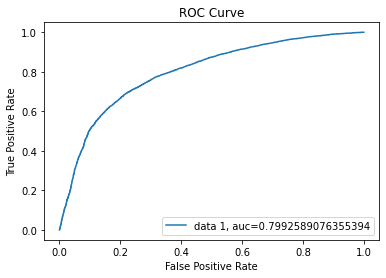

In [29]:
#final classification model
gbc=GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=7, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

gbc.fit(train_x,train_y)
pred=gbc.predict(test_x)
predict_proba = gbc.predict_proba(test_x)[::,1]
score=cross_val_score(gbc,test_x,test_y,cv=10,scoring='accuracy').mean()

print('Model score is:',gbc.score(test_x,test_y),'\n')
print('Accuracy score of model is : ',accuracy_score(test_y,pred),'\n')
print('The mean of cross_val_score for the model is:',score,'\n')

print('Precision score of model is :',precision_score(test_y, pred),'\n')
print('Recall score of model is :',recall_score(test_y, pred),'\n')
print('Log loss score of model is :',log_loss(test_y, pred),'\n')
print('F1_score score of model is :',f1_score(test_y, pred),'\n')

print('Confusion matrix for the model is : \n',confusion_matrix(test_y,pred),'\n')
print('Classification report for the model is : \n',classification_report(test_y,pred),'\n')

fpr, tpr, thresholds  = roc_curve(test_y,  predict_proba)
auc = roc_auc_score(test_y, predict_proba)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr,tpr,label='data 1, auc='+str(auc))
plt.legend(loc=4)
plt.show()

In [30]:
# saving the predection to a csv file.
prediction = pd.DataFrame(pred, columns=['prediction']).to_csv('Assignment 5 Cardiovascular Disease Detection.csv')

In [31]:
# saving the model using pickle.
joblib.dump(gbc,'gbc_Assignment 5 Cardiovascular Disease Detection.pkl')

['gbc_Assignment 5 Cardiovascular Disease Detection.pkl']